In [2]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os
from plot_utils import adjust_plot
import matplotlib.pyplot as plt
from utils import Histfit




awkward version  1.10.3
coffea version  0.7.21
awkward version  1.10.3
coffea version  0.7.21


In [3]:
import mplhep as hep
hep.style.use("CMS")
plt.rcParams['figure.dpi'] = 60

In [4]:
#Function to read the JRfiles and determine the JER for certain ranges of eta, rho and pt

def computeJER(pt, eta, rho, filename):
    df = pd.read_csv( filename, delimiter='\s+', skiprows = 1, names = ['eta_low','eta_high', 'rho_low', 'rho_high', 'unknown','pt_low','pt_high','par0','par1','par2','par3'])
    
    df = df[ (eta > df['eta_low']) &  (eta <= df['eta_high']) & (rho > df['rho_low']) & (rho <= df['rho_high'])  ]
    p0 = df['par0']
    p1 = df['par1']
    p2 = df['par2']
    p3 = df['par3']
    x = pt
    return np.sqrt(p0*np.abs(p0)/(x*x)+p1*p1*np.power(x,p3) + p2*p2)

In [22]:

class QCDProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        frac_axis = hist.axis.Regular(300, 0, 2.0, name="frac", label=r"Fraction")
        ptgen_axis = hist.axis.Variable([200,260,350,460,550,650,760,13000], name="ptgen", label=r"p_{T,RECO} (GeV)")
        n_axis = hist.axis.Regular(5, 0, 5, name="n", label=r"Number")
        pt_axis = hist.axis.Variable([10 ,  11  , 12 ,  13  , 14  , 15 ,  17,
       20  , 23  , 27   ,30  , 35   ,40  , 45 ,  57 ,  72  , 90  , 120 ,  150,
       200  , 300 ,  400   ,550 ,  750 ,  1000 ,  1500  , 2000 ,  2500  , 3000,
       3500 ,  4000  ,  5000   ,10000], name="pt", label=r"$p_{T}$ [GeV]") #erased 4000 and 5000

        
        
        
        
        pileup_axis = hist.axis.Variable([0, 10, 20, 31 , 43, 56],name = "pileup", label = r"$\mu$" )     
        pileup_fine_axis = hist.axis.Regular(30, 0, 40, name = 'pileup_fine', label = r"$\mu$")
        
        rho_axis = hist.axis.Variable( [0, 7.47, 13.49, 19.52, 25.54, 31.57, 37.59, 90], 
                                      name = 'rho', label = r'$\rho$')
        rho_fine_axis = hist.axis.Regular(30, 0, 30, name = 'rho_fine', label = r"$\rho$")
        
        
        #eta_axis = hist.axis.Regular(15, -4,4, name = "eta", label = r"$eta$")
        # eta_axis = hist.axis.Variable([0, 0.261, 0.522, 0.783,  1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853,
        #                               2.964, 3.139, 5],name = "eta", label = r"$\eta$")
        #eta_axis = hist.axis.Variable([-5.191, -3.839, -3.489, -3.139, -2.964, -2.853, -2.65, -2.5, -2.322,-2.172,-2.043, -1.93, -1.74, -1.566,-1.305,-1.044 ,-0.783 ,-0.522, -0.261, 0, 0.261, 0.522, 0.783, 1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853,], name = "eta", label = r"$\eta$")
        
        #eta_axis = hist.axis.Variable([0, 1.305,  2.5, 2.65, 2.853,
                                        #5.191],name = "eta", label = r"$\eta$")
        
        eta_axis = hist.axis.Variable([ 0, 0.5, 0.8, 1.1, 1.3, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3, 3.2, 4.7],name = "eta", label = r"$\eta$")
        
        
        jer_axis = hist.axis.Regular(100, 0.995, 1.030, name = 'jer', label = "JER" )
        
        
        h_njet_gen = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")  #not in use
        h_njet_reco = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts") #not in use
        
        h_pt_reco_over_gen = hist.Hist( dataset_axis, pt_axis, frac_axis, eta_axis, rho_axis, pileup_axis, storage = "weight", label = "Counts")
        #h_pt_reco_over_raw = hist.Hist( dataset_axis, pt_raw_axis,n_axis, frac_axis, eta_axis, pileup_axis, storage = "weight", label = "Counts")
        
        
        h_pileup_rho = hist.Hist(dataset_axis, pileup_fine_axis, rho_fine_axis, storage = "weight", label = "Counts") #used to make pileup vs rho plot
        
        
        
        #self.df = pd.read_csv( "Summer19UL17_JRV2_MC_PtResolution_AK4PFchs.txt", delimiter='\s+', skiprows = 1, names = ['eta_low','eta_high', 'rho_low', 'rho_high', 'unknown','pt_low','pt_high','par0','par1','par2','par3'])
        cutflow = {}

        
        self.hists = {
            "njet_gen":h_njet_gen,
            "njet_reco":h_njet_reco,
            "pt_reco_over_gen": h_pt_reco_over_gen,
            "pileup_rho": h_pileup_rho,
            "cutflow": cutflow
        }
        
    @property
    def accumulator(self):
        return self.hists
    
    def process(self, events):
        dataset = events.metadata['dataset']
        
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            


        gen_vtx = events.GenVtx.z
        reco_vtx = events.PV.z
        
        
        # delta_z < 0.2 between reco and gen
        events = events[np.abs(gen_vtx - reco_vtx) < 0.2]
        
        
        # loose jet ID
        events.Jet = events.Jet[events.Jet.jetId > 0]
        

        events = events[ak.num(events.Jet) > 0 ]
        dataset = events.metadata['dataset']
        
        genjets = events.GenJet[:,0:3]
        recojets = genjets.nearest(events.Jet, threshold = 0.2)
        
        sel = ~ak.is_none(recojets, axis = 1)
        
        genjets = genjets[sel]
        recojets = recojets[sel]
             
        ptresponse = recojets.pt/genjets.pt
        
        n_reco_vtx = events.PV.npvs #the number of primary vertices
        n_pileup = events.Pileup.nPU #number of pileupss
        rho = events.fixedGridRhoFastjetAll

        sel = ~ak.is_none(ptresponse,axis=1)
        ptresponse = ptresponse[sel]
        recojets = recojets[sel]
        genjets = genjets[sel]
        
        sel2 = ak.num(ptresponse) > 2
        
        recojets = recojets[sel2]
        genjets = genjets[sel2]
        
        ptresponse = ptresponse[sel2]
        ptresponse_raw = (recojets.pt * (1 - recojets.rawFactor))/genjets.pt
        
        n_reco_vtx = n_reco_vtx[sel2]
        n_pileup = n_pileup[sel2]
        rho = rho[sel2]
        
        n_reco_vtx = ak.broadcast_arrays(n_reco_vtx, recojets.pt)[0]
        n_pileup = ak.broadcast_arrays(n_pileup, recojets.pt)[0]
        rho = ak.broadcast_arrays(rho, recojets.pt)[0]
                
        
        self.hists["pt_reco_over_gen"].fill( dataset = dataset, pt = ak.flatten(genjets.pt),frac = ak.flatten(ptresponse), 
                                            rho = ak.flatten(rho), eta = np.abs(ak.flatten(genjets.eta)), pileup = ak.flatten(n_pileup))
        
        #self.hists["pt_reco_over_raw"].fill( dataset = dataset, pt_raw = ak.flatten(recojets.pt*(1 - recojets.rawFactor)), n = ak.flatten(n_reco_vtx) ,frac = ak.flatten(ptresponse_raw), eta = np.abs(ak.flatten(genjets.eta)), pileup = ak.flatten(n_pileup))
        
        self.hists["pileup_rho"].fill(dataset = dataset, rho_fine = ak.flatten(rho), pileup_fine = ak.flatten(n_pileup))
            
        return self.hists
    
    def postprocess(self, accumulator):
        return accumulator
        

In [23]:
# fileset = {}
# filedir = "samples/"
# prependstr = 'root://xcache/'


# # eras_mc = [
# #         'UL16NanoAODv9', 
# #         'UL16NanoAODAPVv9',
# #         'UL17NanoAODv9', 
# #         'UL18NanoAODv9'
# #     ]
# eras_mc = ['UL18NanoAODv9']
# eras = ['2016', '2016APV', '2017', '2018']


# qcd_mc_filestr = "QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_"

# for era in eras_mc:
#     fileset[era] = {}
#     filename = filedir + qcd_mc_filestr + era + ".txt"
#     with open(filename) as f:
#         dy_mc_files = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#" ]
#         fileset[era] = dy_mc_files

In [24]:
# Set year and era here
year = 2018
era = "2018"

In [25]:
prependstr = 'root://xcache/'

fileset = {}



if era == "2016":
    jerfile = "Summer20UL16_JRV3_MC_PtResolution_AK4PFchs.txt"
    filename = 'samples/flatPU_JMENano_2016.txt'
if era == '2016APV':
    jerfile = "Summer20UL16APV_JRV3_MC_PtResolution_AK4PFchs.txt"    
    filename = 'samples/flatPU_JMENano_2016APV.txt'
if era == '2017':
    jerfile = "Summer19UL17_JRV2_MC_PtResolution_AK4PFchs.txt"
    filename = 'samples/flatPU_JMENano_2017.txt'
if era == '2018':
    jerfile = "Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.txt"
    filename = 'samples/flatPU_JMENano_2018.txt'

    
eras = ['2018']
for era in eras:
    with open(filename) as f:
        files = [prependstr + i.rstrip() for i in f.readlines() if i[0] != '#']
        fileset[era] =  files
    
    

In [26]:
test = True
if test == True:
    fileset[era] = fileset[era][:1]

In [27]:
#f = uproot.open("/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/894A5559-C6A2-7347-9C7C-2FB1EDDCCEA1.root")


In [28]:
# from dask.distributed import Client

# client = Client("tls://localhost:8786")
# #client = None

In [29]:
# run = processor.Runner(
#             executor = processor.DaskExecutor(client = client),
#             schema=NanoAODSchema,
#             skipbadfiles=True
#         )

In [30]:
run = processor.Runner(
            executor = processor.FuturesExecutor(workers = 2),
            schema=NanoAODSchema,
            skipbadfiles=True
        )

In [35]:
output = run(
    fileset,
    "Events",
    processor_instance=QCDProcessor(),
)

fname_out = 'QCDresponse_'+era+'JME'+'.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( output, f )

Output()

In [33]:
#!cp "QCDresponse.pkl" "QCDresponse_all.pkl"

In [37]:
with open('QCDresponse_'+era+'JME'+'.pkl', "rb") as f:
    output = pickle.load( f )

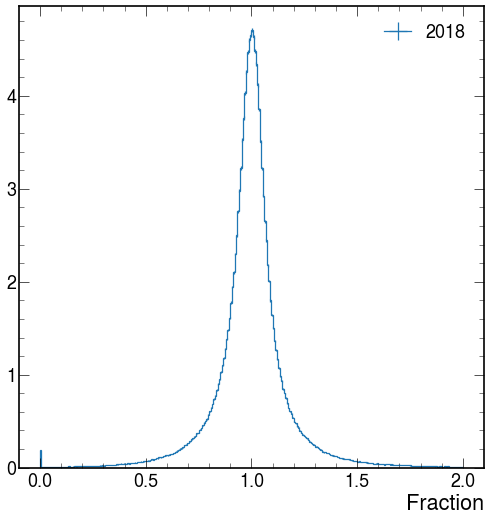

In [38]:
output["pt_reco_over_gen"].project('dataset','frac').plot(density=True)
plt.legend()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8298fb46a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8298fc6850>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8298fd8b20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8298fe5df0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

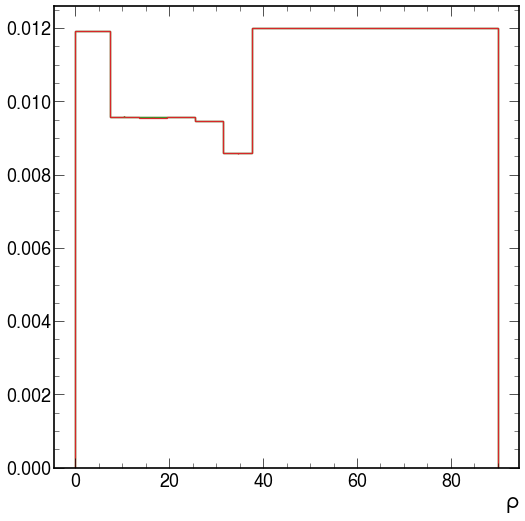

In [9]:
output["pt_reco_over_gen"].project('dataset','rho').plot(density = True)

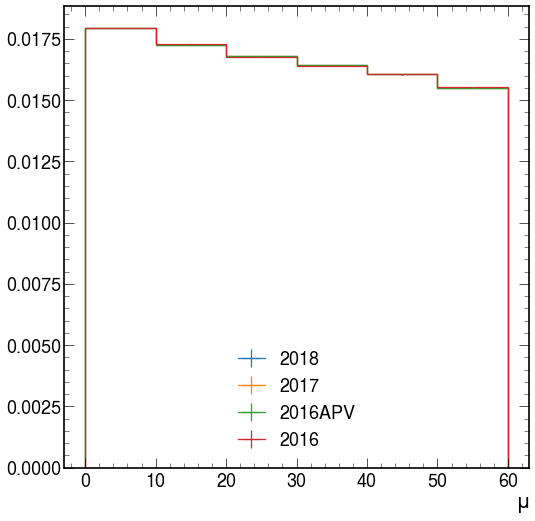

In [10]:
output["pt_reco_over_gen"].project('dataset','pileup').plot(density = True)
plt.legend()

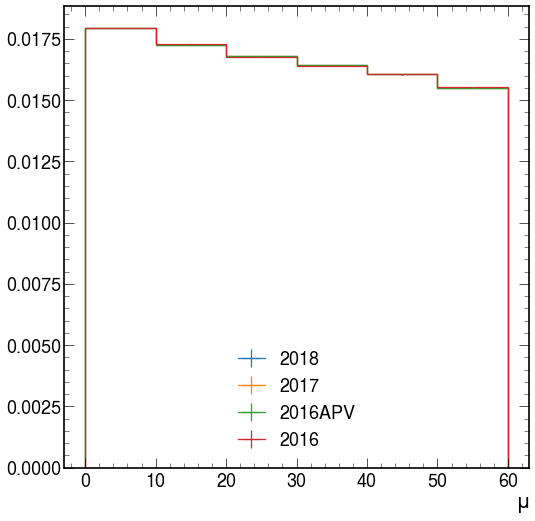

In [11]:
output["pt_reco_over_gen"].project('dataset','pileup').plot(density = True)
plt.legend()

### Bin Edges

In [12]:
hist = output["pt_reco_over_gen"]
hist.axes

(StrCategory(['2018', '2017', '2016APV', '2016'], growth=True, name='dataset', label='Primary dataset'),
 Variable(array([   10.,    11.,    12.,    13.,    14.,    15.,    17.,    20.,
           23.,    27.,    30.,    35.,    40.,    45.,    57.,    72.,
           90.,   120.,   150.,   200.,   300.,   400.,   550.,   750.,
         1000.,  1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  5000.,
        10000.]), name='pt', label='$p_{T}$ [GeV]'),
 Regular(300, 0, 2, name='frac', label='Fraction'),
 Variable([0, 0.5, 0.8, 1.1, 1.3, 1.7, 1.9, 2.1, 2.3, 2.5, 2.8, 3, 3.2, 4.7], name='eta', label='$\\eta$'),
 Variable([0, 7.47, 13.49, 19.52, 25.54, 31.57, 37.59, 90], name='rho', label='$\\rho$'),
 Variable([0, 10, 20, 30, 40, 50, 60], name='pileup', label='$\\mu$'))

In [13]:
hist = output["pt_reco_over_gen"]
datasets = hist.axes[0].centers
pt_bins = hist.axes[1].edges
frac_bins = hist.axes[2].edges
eta_bins = hist.axes[3].edges
rho_bins = hist.axes[4].edges

### Bin centers

In [14]:

pt_values = hist.axes[1].centers
frac_values = hist.axes[2].centers
eta_values = hist.axes[3].centers
rho_values = hist.axes[4].centers

### Bin Widths

In [15]:
pt_widths = hist.axes[1].widths
frac_widths = hist.axes[2].widths
eta_widths = hist.axes[3].widths
rho_widths = hist.axes[4].widths

In [16]:
frac_values.shape

(300,)

In [17]:
eta_values

array([0.25, 0.65, 0.95, 1.2 , 1.5 , 1.8 , 2.  , 2.2 , 2.4 , 2.65, 2.9 ,
       3.1 , 3.95])

In [18]:
rho_bins

array([ 0.  ,  7.47, 13.49, 19.52, 25.54, 31.57, 37.59, 90.  ])

In [19]:
hist_np = hist.to_numpy()[0]

hist_np.shape

(4, 32, 300, 13, 7, 6)

In [20]:
hist_frac = hist.project("dataset","frac").to_numpy()[0]

In [21]:
np.shape(hist_frac)

(4, 300)

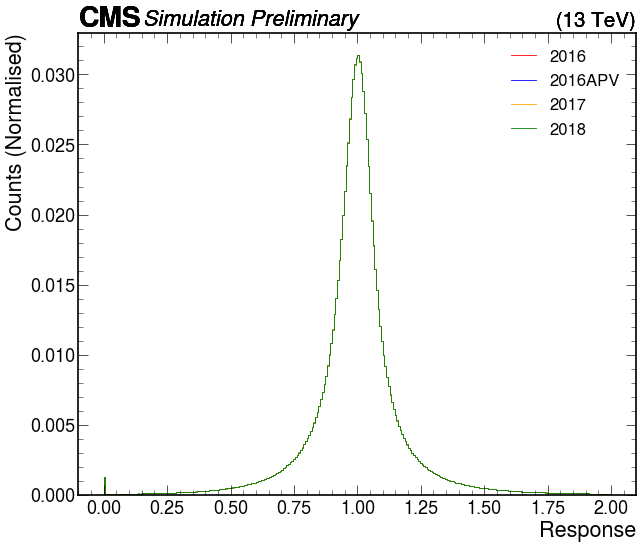

In [22]:
fig = plt.figure(figsize = (12,10))
colors = ['red', 'blue', 'orange' , 'green']
for i in range(len(datasets)):
    plt.stairs( hist_frac[i]/np.sum(hist_frac[i]),frac_bins,  label = eras[i], color = colors[i])
    plt.xlabel("Response")
    plt.legend(loc = 'upper right', fontsize = 20)
    plt.ylabel("Counts (Normalised)")
    hep.cms.label("Preliminary")

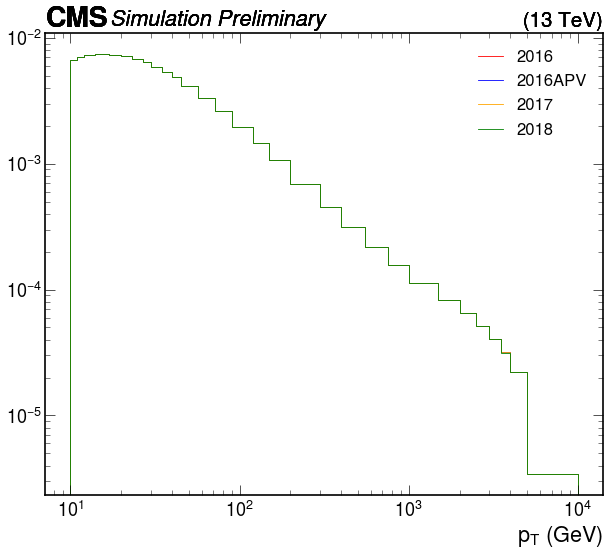

In [23]:
hist_pt = hist.project("dataset","pt").to_numpy()[0]
colors = ['red', 'blue', 'orange' , 'green']
fig = plt.figure(figsize = (12,10))
for i in range(len(datasets)):
    plt.stairs( hist_pt[i]/(np.sum(hist_pt[i])* pt_widths),pt_bins,  label = eras[i], color = colors[i])
    plt.xlabel(r"$p_T$ (GeV)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc = 'upper right', fontsize = 20)
    hep.cms.label("Preliminary")

In [24]:
#hist_frac_pt = np.sum(hist_np, axis = (0,2,4,5) )
hist_frac_pt = hist.project("pt","frac").to_numpy()[0]

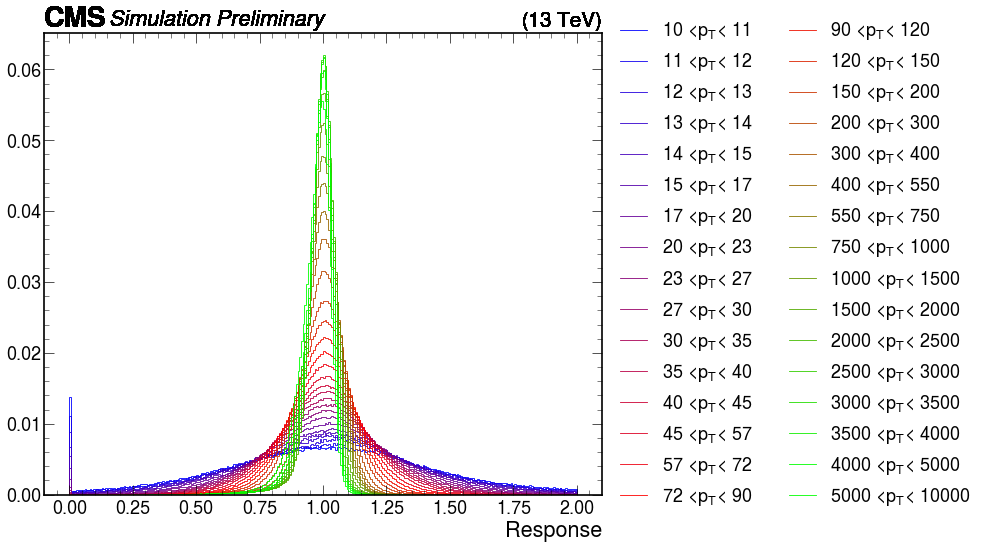

In [25]:
cm = plt.get_cmap('brg')
colors = [cm(1.*i/30) for i in range(len(pt_values))]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(len(pt_values)):
    ax.stairs( hist_frac_pt[i]/np.sum(hist_frac_pt[i]),frac_bins,  label = str(int(pt_bins[i]))+r" <$p_T$< "  + str(int(pt_bins[i+1])) )
    ax.set_xlabel("Response")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    hep.cms.label("Preliminary")

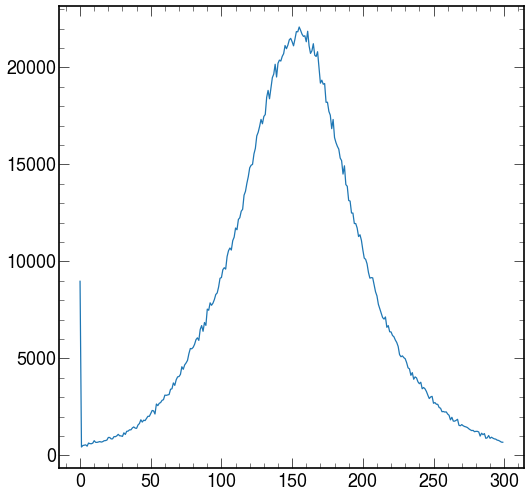

In [26]:
plt.plot(hist_frac_pt[5])

In [35]:
from utils import Histfit

hist_frac_dataset_pt = hist.project("dataset", "pt","frac").to_numpy()[0]

histfit = Histfit(hist_frac_pt, frac_values, pt_values)

In [30]:
histfit.store_parameters()

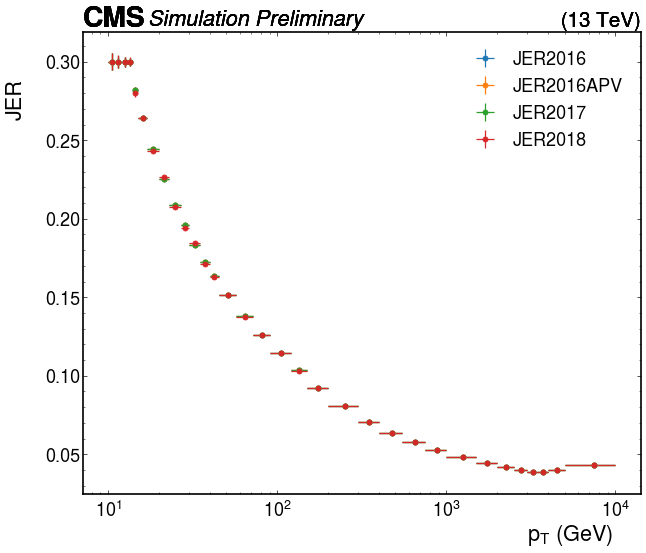

In [39]:
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
for i_data in range(4):
    hist_frac_pt = hist_frac_dataset_pt[i_data]
    histfit = Histfit(hist_frac_pt, frac_values, pt_values)
    histfit.store_parameters()
    sigma_list = histfit.parameters["sigma"]
    sigma_error_list  = histfit.parameters["sigmaErr"]
    
    ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", label = r'JER'+eras[i_data])
    #plt.xlabel(r"$p_T$ (GeV)")
    adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
    hep.cms.label("Preliminary")
    plt.legend()
    #plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

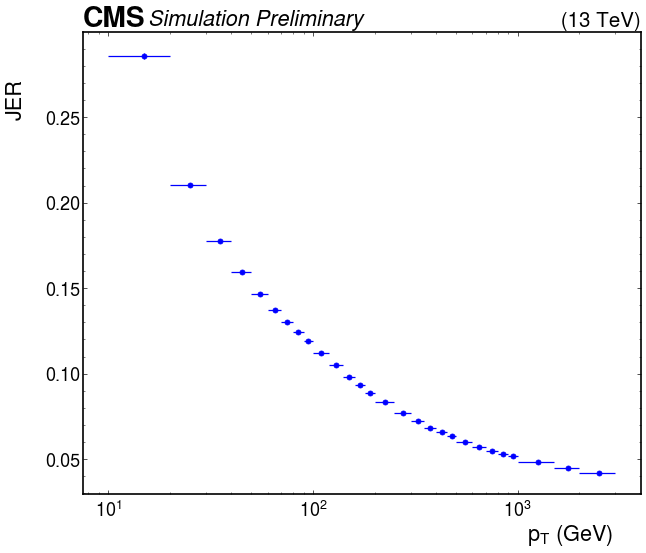

In [42]:
sigma_list = histfit.parameters["sigma"]
sigma_error_list  = histfit.parameters["sigmaErr"]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
hep.cms.label("Preliminary")
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

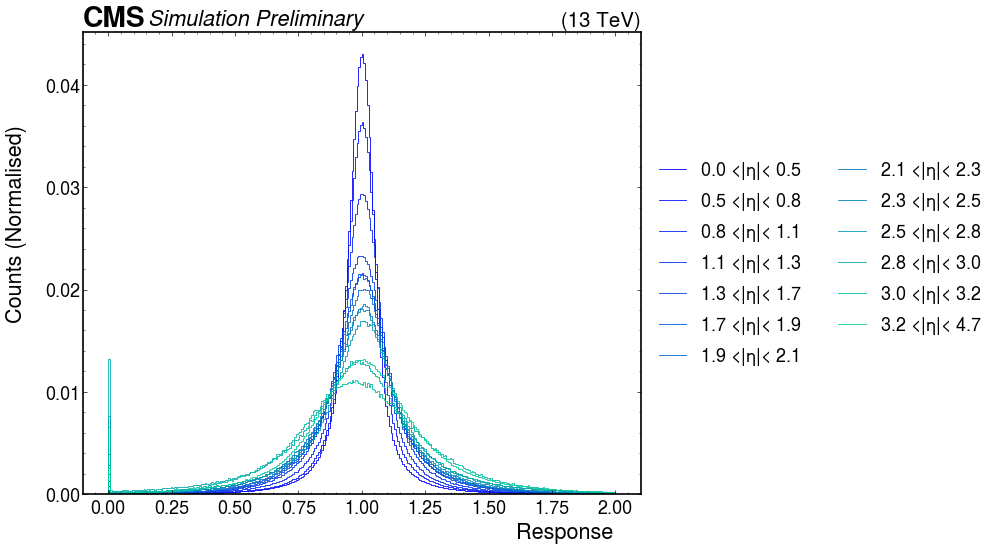

In [41]:
#hist_frac_eta = np.sum(hist_np, axis = (0,1,2,5) )
#hist_frac_eta = hist_frac_eta.T
fig = plt.figure(figsize = (12,10))

hist_frac_eta = hist.project('eta','frac').to_numpy()[0]
cm = plt.get_cmap('winter')
colors = [cm(1.*i/15) for i in range(len(eta_values))]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(len(eta_values)):
    ax.stairs( hist_frac_eta[i]/np.sum(hist_frac_eta[i]),frac_bins,  label = str(round(eta_bins[i],2))+r" <$|\eta|$< "  + str(round(eta_bins[i+1],2)) )
    ax.set_xlabel("Response")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
hep.cms.label("Preliminary")

In [42]:
histfit_eta = Histfit(hist_frac_eta, frac_values, eta_values)
histfit_eta.store_parameters()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

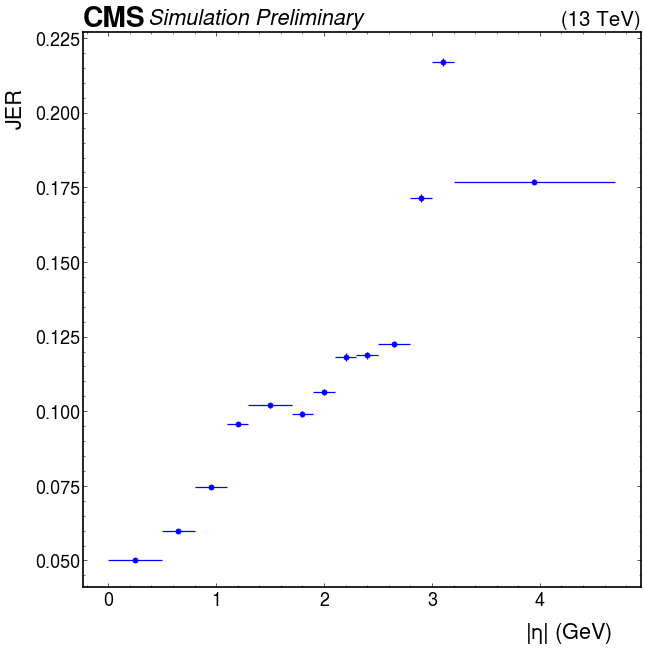

In [43]:
fig = plt.figure(figsize = (12,12))
sigma_list = histfit_eta.parameters["sigma"]
sigma_error_list  = histfit_eta.parameters["sigmaErr"]

ax = plt.subplot()
ax.errorbar(eta_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = eta_widths/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$|\eta|$ (GeV)", ylabel = "JER")
#plt.xscale("log")
hep.cms.label("Preliminary")

In [47]:
# fig = plt.figure(figsize = (12,10))
# hist_frac_pileup = hist.project("pileup","frac").to_numpy()[0]
# cm = plt.get_cmap('brg')
# colors = [cm(1.*i/9) for i in range(9)]
# ax = plt.subplot()
# ax.set_prop_cycle(color=colors)
# for i in range(7):
#     ax.stairs( hist_frac_pileup[i]/np.sum(hist_frac_pileup[i]),frac_bins,  label = str(int(pileup_bins[i]))+r" <$\mu$< "  + str(int(pileup_bins[i+1])) )
#     ax.set_xlabel("Response")
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
# adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
# ax.legend() 
# hep.cms.label("Preliminary")

In [48]:

    
# histfit_frac_pileup = Histfit(hist_frac_pileup, frac_values, pileup_values)
# histfit_frac_pileup.store_parameters()

In [49]:
# sigma_list = histfit_frac_pileup.parameters["sigma"]
# sigma_error_list  = histfit_frac_pileup.parameters["sigmaErr"]

# ax = plt.subplot()
# ax.errorbar(pileup_values[:], sigma_list[:], np.power(sigma_error_list[:], 0.5), xerr = pileup_widths[:]/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
# adjust_plot(ax, xlabel = r"$\mu$ ", ylabel = "JER")


In [50]:
# import itertools
# ax = plt.subplot()
# markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
# for i_pileup, hist_pt_frac in enumerate(hist_pileup_pt_frac):
#     histfit = Histfit(hist_pt_frac, frac_values, pt_values)
#     histfit.store_parameters()
    
#     sigma_list = histfit.parameters["sigma"]
#     sigma_error_list  = histfit.parameters["sigmaErr"]

#     ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(pileup_bins[i_pileup],2))+r" <$\mu$< "  + str(round(pileup_bins[i_pileup+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
#     plt.xlabel(r"$p_T$ (GeV)")
#     plt.xscale("log")
#     hep.cms.label("Preliminary")
#     plt.legend()
#     #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')

In [51]:
# hist_eta_pileup_pt_frac = hist.project("eta","pileup","pt","frac").to_numpy()[0]

In [52]:

# markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
# for i_eta,hist_pileup_pt_frac in enumerate(hist_eta_pileup_pt_frac):
#     ax = plt.subplot()
#     for i_pileup, hist_pt_frac in enumerate(hist_pileup_pt_frac):
#         histfit = Histfit(hist_pt_frac, frac_values, pt_values)
#         histfit.store_parameters()

#         sigma_list = histfit.parameters["sigma"]
#         sigma_error_list  = histfit.parameters["sigmaErr"]

        
#         ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(pileup_bins[i_pileup],2))+r" <$\mu$< "  + str(round(pileup_bins[i_pileup+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
        
#         plt.xlabel(r"$p_T$ (GeV)")
#         plt.ylabel("JER")
#         plt.xscale("log")
#         hep.cms.label("Preliminary")
#         plt.legend()
#         #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')
#     ax.text(s = str(round(eta_bins[i_eta],3))+ r" <$\eta$< " + str(round(eta_bins[i_eta + 1],3)), x = 0.35, y = 0.93, fontsize = 21, transform=ax.transAxes)
#     plt.show()

In [53]:

# histfit = Histfit(hist_eta_pileup_pt_frac[10][5], frac_values, pt_values)
# histfit.store_parameters()

In [54]:
# sigma_list = histfit.parameters["sigma"]
# sigma_error_list  = histfit.parameters["sigmaErr"]
# fig = plt.figure(figsize = (12,10))
# ax = plt.subplot()
# ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
# #plt.xlabel(r"$p_T$ (GeV)")
# adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
# hep.cms.label("Preliminary")
# #plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

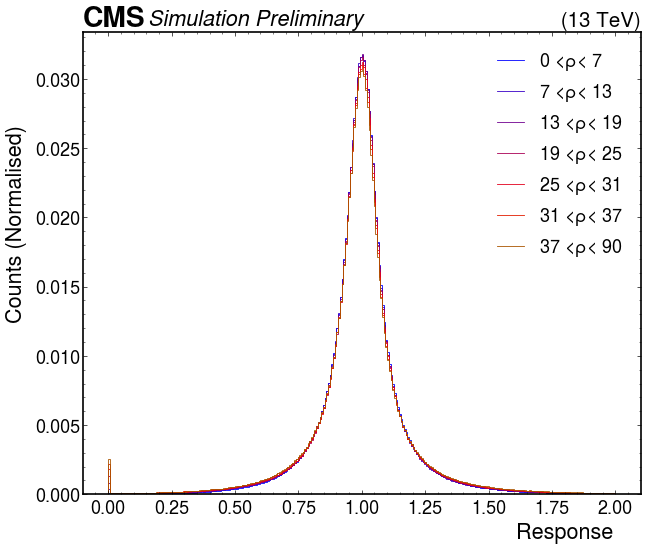

In [46]:
fig = plt.figure(figsize = (12,10))
hist_frac_rho = hist.project("rho","frac").to_numpy()[0]
cm = plt.get_cmap('brg')
colors = [cm(1.*i/9) for i in range(len(rho_values))]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(7):
    ax.stairs( hist_frac_rho[i]/np.sum(hist_frac_rho[i]),frac_bins,  label = str(int(rho_bins[i]))+r" <$\rho$< "  + str(int(rho_bins[i+1])) )
    ax.set_xlabel("Response")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
ax.legend() 
hep.cms.label("Preliminary")

In [56]:
histfit_frac_rho = Histfit(hist_frac_rho, frac_values, rho_values)
histfit_frac_rho.store_parameters()

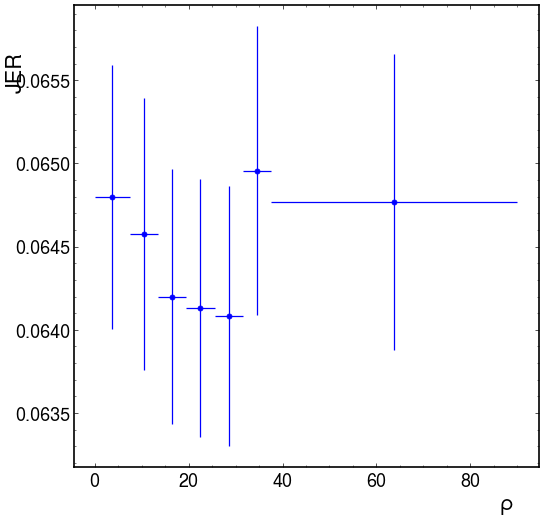

In [57]:
sigma_list = histfit_frac_rho.parameters["sigma"]
sigma_error_list  = histfit_frac_rho.parameters["sigmaErr"]

ax = plt.subplot()
ax.errorbar(rho_values[:], sigma_list[:], np.power(sigma_error_list[:], 0.5), xerr = rho_widths[:]/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$\rho$ ", ylabel = "JER")
#plt.xscale("log")

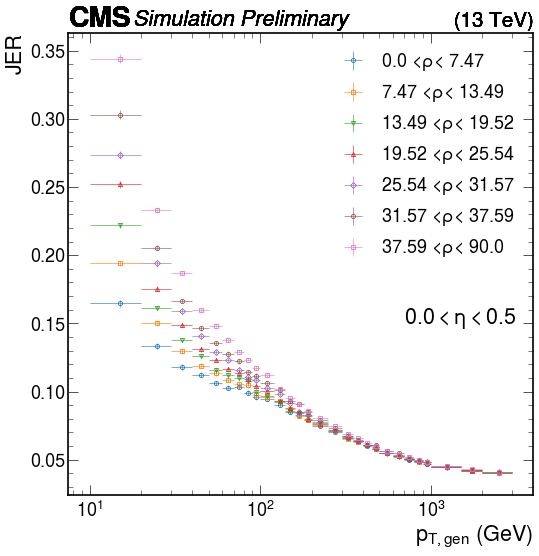

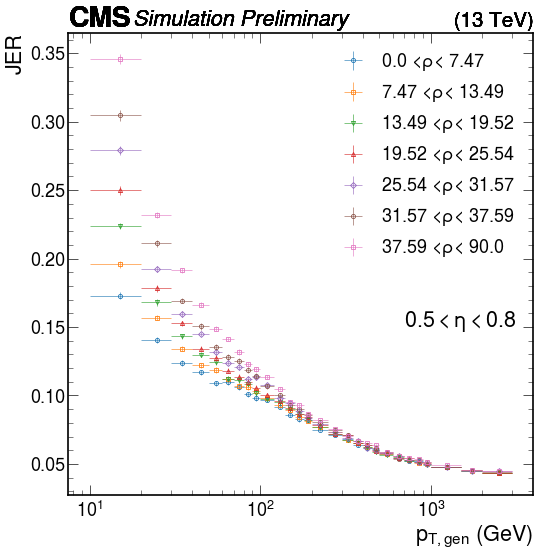

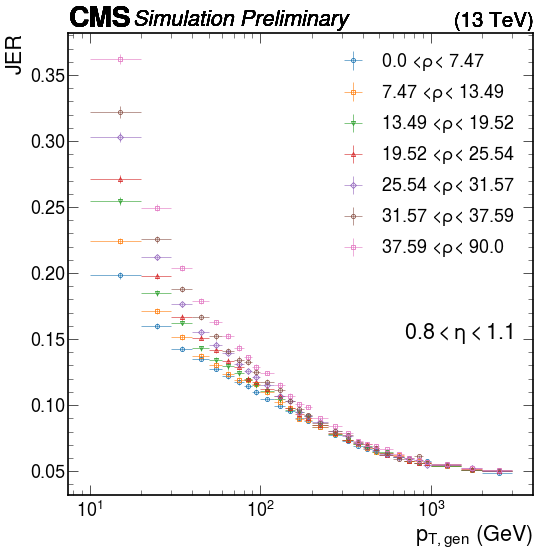

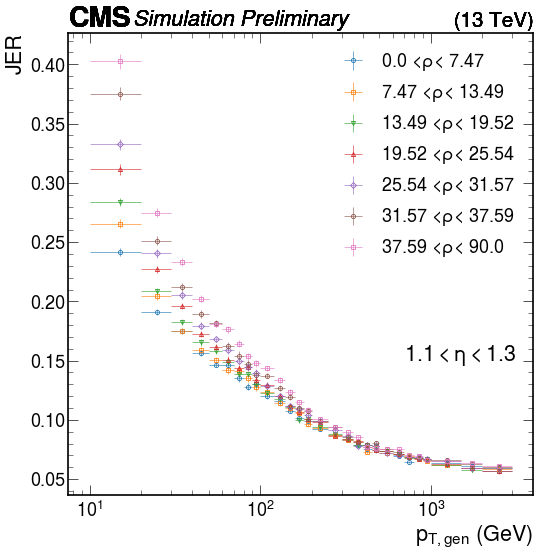

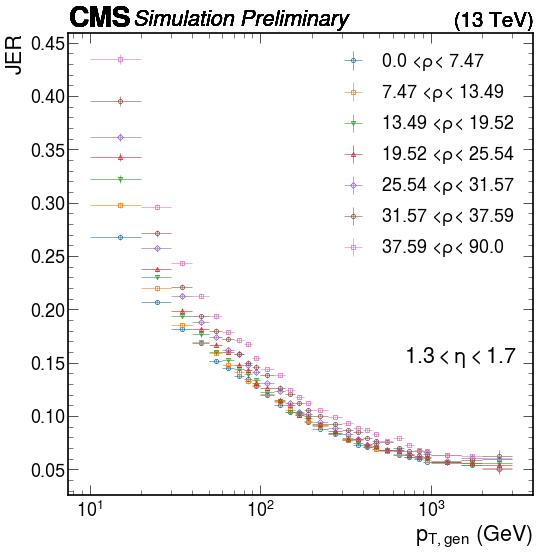

In [58]:
hist_eta_rho_pt_frac = hist.project("eta","rho","pt","frac").to_numpy()[0]
for i, hist_rho_pt_frac in enumerate(hist_eta_rho_pt_frac):
    if i == 5:
        break
    import itertools
    ax = plt.subplot()
    markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
    for i_rho, hist_pt_frac in enumerate(hist_rho_pt_frac):
        histfit = Histfit(hist_pt_frac, frac_values, pt_values)
        histfit.store_parameters()

        sigma_list = histfit.parameters["sigma"]
        sigma_error_list  = histfit.parameters["sigmaErr"]

        
        ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(rho_bins[i_rho],2))+r" <$\rho$< "  + str(round(rho_bins[i_rho+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
        plt.xlabel(r"$p_{T,gen}$ (GeV)")
        plt.ylabel("JER")
        plt.xscale("log")
        
        hep.cms.label("Preliminary")
        plt.legend()
    plt.text(700, 0.15, str(round(eta_bins[i],1))+r'$ <\eta< $'+str(round(eta_bins[i+1],1)))
    plt.show()
        #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')

In [59]:
from utils import Histfit
import pandas as pd
hist = output["pt_reco_over_gen"]


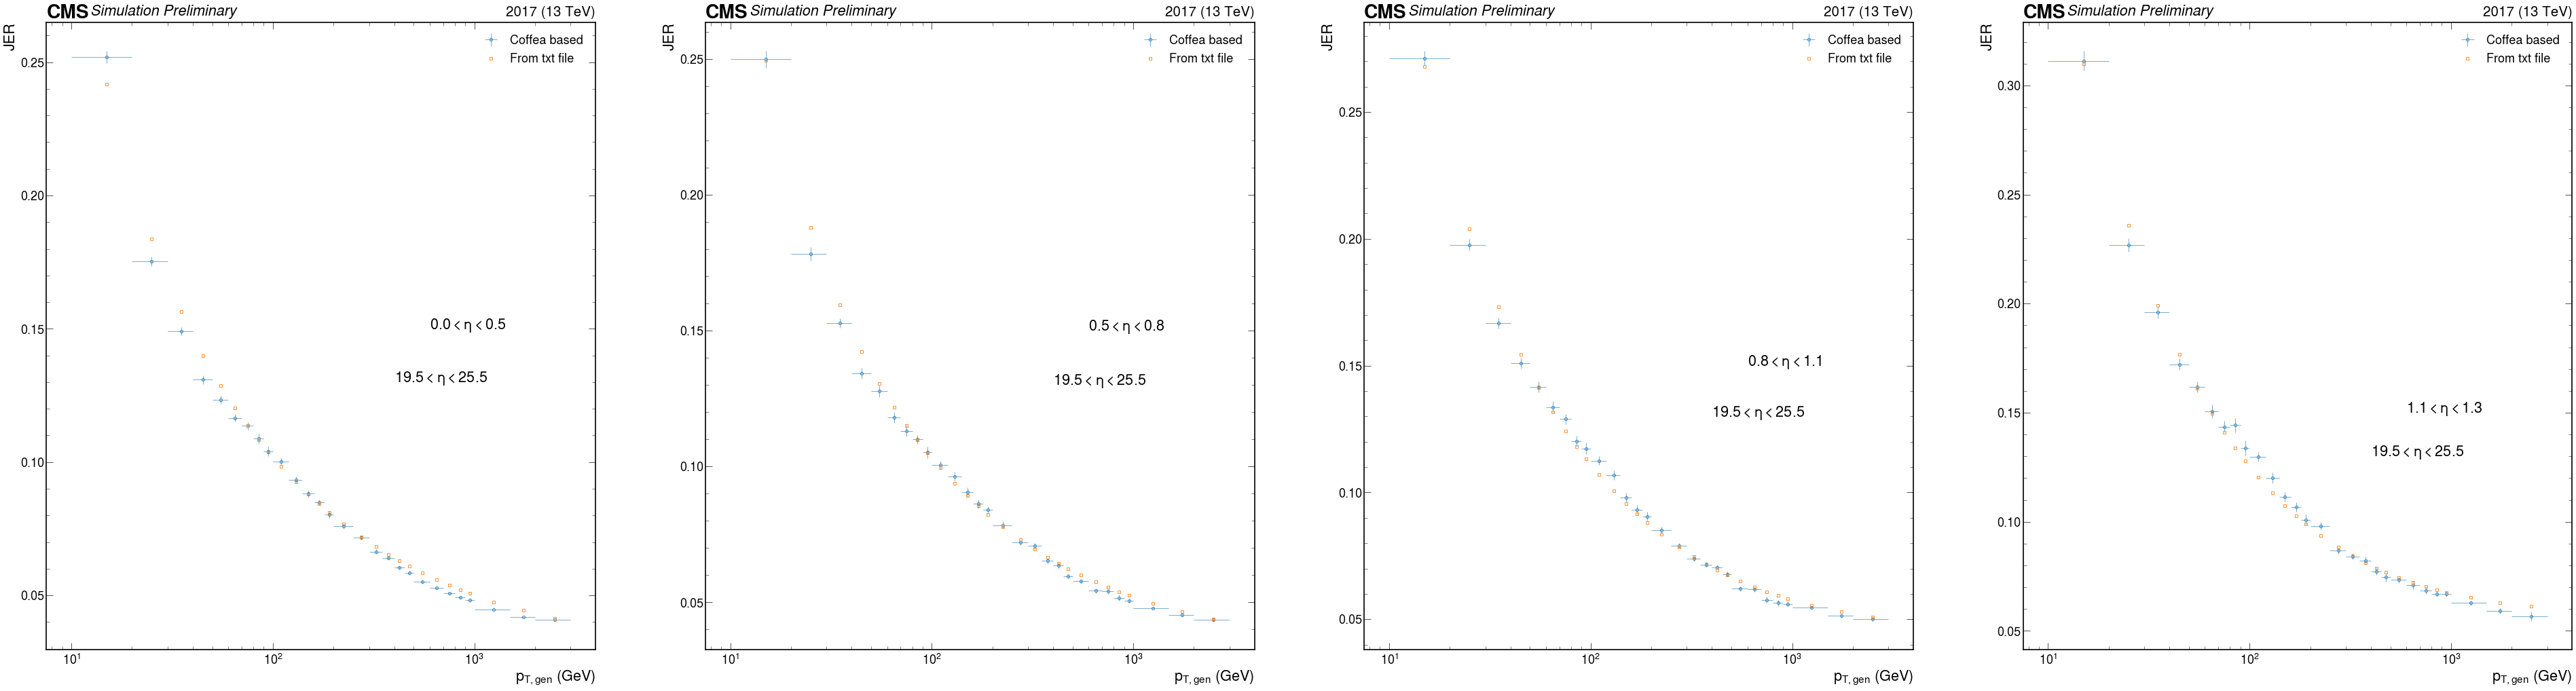

In [65]:
import itertools
plt.figure(figsize = (80,20))
for i_eta in range(4):
    hist_rho_pt_frac = hist.project("eta","rho","pt","frac").to_numpy()[0][i_eta]
    ax = plt.subplot(1,4,i_eta+1)
    markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
    i_rho = 3
    hist_pt_frac = hist_rho_pt_frac[i_rho]
    histfit = Histfit(hist_pt_frac, frac_values, pt_values)
    histfit.store_parameters()

    sigma_list = histfit.parameters["sigma"]
    sigma_error_list  = histfit.parameters["sigmaErr"]


    ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  
                label ="Coffea based", fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)

    plt.xlabel(r"$p_{T,gen}$ (GeV)")
    plt.ylabel("JER")
    plt.xscale("log")


    plt.errorbar(x = pt_values, y = [computeJER(pt = pt,eta = eta_values[i_eta],rho = rho_values[i_rho], filename = jerfile) for pt in pt_values], fmt = next(markers) ,
                     label = "From txt file",linestyle = "", markersize = 5, markerfacecolor='none')

    hep.cms.label("Preliminary", year = year)

    hep.cms.annotations
    plt.legend()
    plt.text(600, 0.15, str(round(eta_bins[i_eta],1))+r'$ <\eta< $'+str(round(eta_bins[i_eta+1],1)))
    plt.text(400, 0.13, str(round(rho_bins[i_rho],1))+r'$ <\eta< $'+str(round(rho_bins[i_rho+1],1)))


<ErrorbarContainer object of 3 artists>

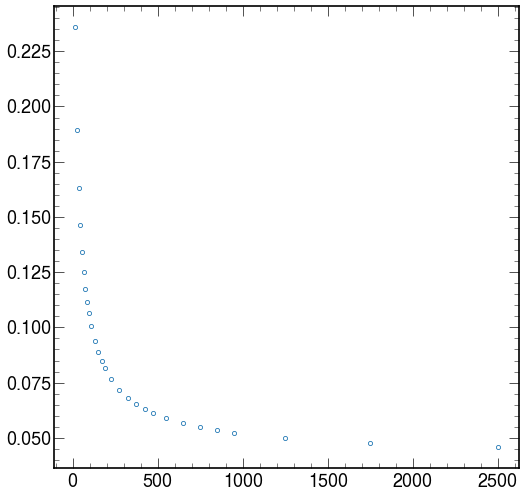

In [106]:
jerfile18 = "Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.txt"
plt.errorbar(x = pt_values, y = [computeJER(pt = pt,eta = 0.2,rho = 20, filename = jerfile18) for pt in pt_values], fmt = next(markers) ,
                 label = str(round(rho_bins[i_rho],2))+r" <$\rho$< "  + str(round(rho_bins[i_rho+1],2)),linestyle = "", markersize = 5, markerfacecolor='none')